## Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [1]:
#Connect Google drive to colab
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#### Change your present working directory

### Load your data file

In [2]:
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from matplotlib import pyplot as plt
import seaborn as sns
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import adam


Using TensorFlow backend.


In [0]:
data = pd.read_csv("daily-minimum-temperatures-in-me.csv",index_col='Date')

#### Plot data

In [4]:
data.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Descibe your dataframe

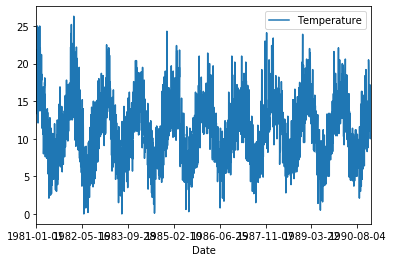

In [5]:
data.plot()

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


#### Check for null values

In [7]:
data.isnull().sum()

Temperature    0
dtype: int64

In [8]:
data.dtypes

Temperature    float64
dtype: object

#### Drop null values

In [0]:
#

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66bbc8eda0>]],
      dtype=object)

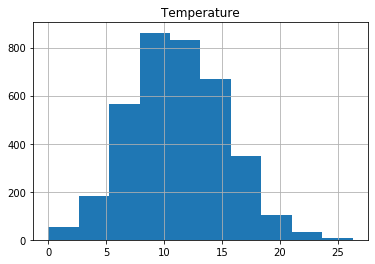

In [10]:
data.hist()

#### Check the maximum and minimum values

In [11]:
print(max(data.Temperature))
print(min(data.Temperature))

26.3
0.0


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

In [0]:
scaled_data = pd.DataFrame(data=scaled,columns=['Temperature'],index=data.index)

In [14]:
scaled_data.head()

,Temperature
Date,
1981-01-01,0.787072
1981-01-02,0.680608
1981-01-03,0.714829
1981-01-04,0.555133
1981-01-05,0.600760


#### Check the maximum and minimum values of scaled data

In [15]:
print(max(scaled))
print(min(scaled))

[1.]
[0.]


#### Look into some of the scaled values

In [16]:
scaled_data.head()

,Temperature
Date,
1981-01-01,0.787072
1981-01-02,0.680608
1981-01-03,0.714829
1981-01-04,0.555133
1981-01-05,0.600760


### Split data into Training and Testing

In [0]:

train_data = scaled_data[:int((len(scaled_data))*.70)] 
test_data = scaled_data[int(len(scaled_data)*.70):]

#### Print train and test size

In [18]:
print(train_data.shape)
print(test_data)

(2555, 1)
            Temperature
Date                   
1988-01-01     0.581749
1988-01-02     0.543726
1988-01-03     0.513308
1988-01-04     0.570342
1988-01-05     0.517110
...                 ...
1990-12-27     0.532319
1990-12-28     0.517110
1990-12-29     0.513308
1990-12-30     0.596958
1990-12-31     0.494297

[1095 rows x 1 columns]


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
#def seq_data(dataset):
 #   scaled_data['next_temp'] = scaled_data.shift(periods = -1 )['Temperature'] 
 #   T_x = scaled_data['Temperature']
 #   T_y = scaled_data['next_temp']
 #   return T_x, T_y

In [0]:
def add_col(dffile):
  dffile['Nexttemp']=dffile['Temperature'].shift(-1)
  dffile=dffile[:-1]

In [21]:
add_col(train_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
train_data=train_data[:-1]
train_data.tail()

,Temperature,Nexttemp
Date,,
1987-12-26,0.482890,0.615970
1987-12-27,0.615970,0.539924
1987-12-28,0.539924,0.543726
1987-12-29,0.543726,0.505703
1987-12-30,0.505703,0.634981


In [23]:
add_col(test_data)
test_data=test_data[:-1]
test_data.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Temperature,Nexttemp
Date,,
1990-12-26,0.555133,0.532319
1990-12-27,0.532319,0.517110
1990-12-28,0.517110,0.513308
1990-12-29,0.513308,0.596958
1990-12-30,0.596958,0.494297


In [0]:
X_train=train_data['Temperature']
y_train=train_data['Nexttemp']
X_test=test_data['Temperature']
y_test=test_data['Nexttemp']

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [25]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(np.array(X_train), (X_train.shape[0],1, 1))
X_test = np.reshape(np.array(X_test), (X_test.shape[0],1, 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [26]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(1, 1)))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
model.output

<tf.Tensor 'lstm/strided_slice_7:0' shape=(?, 32) dtype=float32>

In [0]:
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='sgd', loss='mse',metrics=['accuracy'])

### Summarize your model

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4,389
Trainable params: 4,389
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [37]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 1s 279us/sample - loss: 0.0874 - acc: 7.8309e-04 - val_loss: 0.0328 - val_acc: 0.0000e+00
Epoch 2/200
2554/2554 [==============================] - 0s 102us/sample - loss: 0.0253 - acc: 7.8309e-04 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 3/200
2554/2554 [==============================] - 0s 98us/sample - loss: 0.0233 - acc: 7.8309e-04 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 4/200
2554/2554 [==============================] - 0s 104us/sample - loss: 0.0227 - acc: 7.8309e-04 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 5/200
2554/2554 [==============================] - 0s 96us/sample - loss: 0.0223 - acc: 7.8309e-04 - val_loss: 0.0214 - val_acc: 0.0000e+00
Epoch 6/200
2554/2554 [==============================] - 0s 101us/sample - loss: 0.0218 - acc: 7.8309e-04 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 7/200
2554/2554 [==============================] - 0s 96us/sample 

## Make Predictions and Evaluate your model

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [0]:
#Un-normalize the predited data
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

## Plot the results

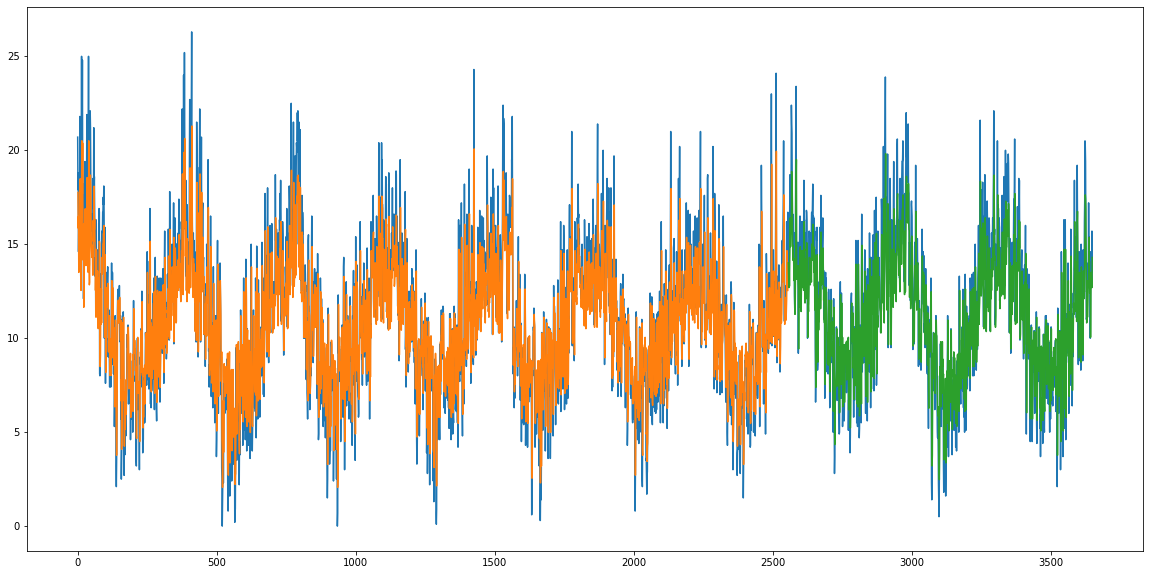

In [34]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(1*2):len(scaled), :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()